NGBoost for outputting Probalitiy Distribution instead of single value

https://stanfordmlgroup.github.io/ngboost/1-useage.html

In [55]:
#Necessary imports
import os
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ngboost import NGBRegressor
from ngboost.scores import LogScore
from ngboost.distns import  Normal
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import optuna
from optuna.trial import TrialState
import uncertainty_toolbox as uct

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

import utils.data_prep as data_prep
import utils.metrices as metrices
import utils.data_prep as set_seed

Data Loading and Preprocessing to compare the algorithms, although Decision Trees are not sensitve to feature scalling, they do not use geometric distances


In [47]:
# load and transform the data, split it into training, validation, and test sets
# uses random state 42 internally for reproducibility
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', 
                                                                                                       split_ratio=(0.6, 0.2, 0.2))

Optuna Hyperparameter Search

In [ ]:
def objective(trial):

    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2,log=True)
    max_depth = trial.suggest_int("max_depth", 4, 20)
    
    # Create the NGBRegressor model with the suggested hyperparameters
    ngb = NGBRegressor(
        Dist=Normal, 
        Score=LogScore, 
        Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth),
        verbose=False, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate
    )
    
    # Fit the model to the training data
    ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)
    
    # Make predictions on the validation set
    y_preds = ngb.predict(X_val)
    y_dists = ngb.pred_dist(X_val)
    
    # Calculate the negative log likelihood
    nll = -y_dists.logpdf(y_val).mean()
    rmse = root_mean_squared_error(y_val, y_preds)
    print(f"Trial {trial.number}: NLL={nll}, RMSE={rmse}")
    
    return nll

Execute Study

In [ ]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed = SEED),  # Use TPE sampler for hyperparameter optimization
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=20,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts
    )
)
study.optimize(objective, n_trials=200, timeout=None, n_jobs=1, show_progress_bar=True)

print(study.best_params)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Train final Model

In [ ]:
SEED = 42
set_seed(SEED)
ngb = NGBRegressor(Dist=Normal, 
                   Score = LogScore, 
                   Base = DecisionTreeRegressor(criterion='friedman_mse',                                                
                                                 max_depth=9,
                                                 random_state=SEED), 
                   verbose = True, 
                   n_estimators=750, 
                   learning_rate=0.003,
                   random_state=SEED)

ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=50)

Evalute 1 Run Using Uncertainty Toolbox to get metrices

In [ ]:
set_seed(SEED)
y_test_preds = ngb.predict(X_test)
y_test_dists = ngb.pred_dist(X_test)
# Extract standard deviation from test predictions
test_stddev = y_test_dists.scale

# Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
pnn_metrics = uct.metrics.get_all_metrics( y_test_preds, test_stddev,y_test)
print(pnn_metrics)
#print(pnn_metrics['accuracy']['rmse'])
# Calculate coverage for 95% confidence interval
coverage_95 = uct.metrics_calibration.get_proportion_in_interval(y_test_preds, test_stddev, y_test, quantile = 0.95 )
print(f"Coverage 95%: {coverage_95}")

# use own function to calculate coverage and MPIW
ev_intervals = metrices.evaluate_intervals(y_test_preds, test_stddev, y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(y_test_preds, test_stddev, y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(y_test_preds, test_stddev, y_test)

Do 10 Runs for a more representative Study

In [48]:
results_list = []
predictions_list = []
list_of_seeds = [42, 123, 777, 2024, 5250, 8888, 9876, 10001, 31415, 54321]
ngb_prediction_path = r"C:\Users\test\Masterarbeit\models\Modelresults\NGBoost"
ngb_result_path = r"C:\Users\test\OneDrive\Master Management und Engineering\Masterarbeit\Experimente\Evaluation\10 Runs\NGBoost"

for run, seed in enumerate(list_of_seeds):

    print(f"Run {run+1} with seed {seed}")
    data_prep.set_seed(seed)

    # Define model, use seed to intialize the base learner and ngboost
    ngb = NGBRegressor(Dist=Normal, 
                        Score = LogScore, 
                        Base = DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=9,
                                                        random_state=seed), 
                        verbose = True, 
                        n_estimators=750, 
                        learning_rate=0.003,
                        random_state=seed)
    
    # Train and evaluate the model
    ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=50)

    # Evaluate on test set
    y_test_preds = ngb.predict(X_test)
    y_test_dists = ngb.pred_dist(X_test)
    # Extract standard deviation from test predictions
    test_stddev = y_test_dists.scale

    # Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
    pnn_metrics = uct.metrics.get_all_metrics( y_test_preds, test_stddev,y_test)
    print(pnn_metrics)

    # use own function to calculate coverage and MPIW
    ev_intervals = metrices.evaluate_intervals(y_test_preds, test_stddev, y_test, coverage=0.95)
    print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

    predictions_per_run = {
        'mean_prediction': y_test_preds,
        'std_prediction': test_stddev,
    }

    results_per_run = {
    'RMSE': pnn_metrics['accuracy']['rmse'],
    'MAE': pnn_metrics['accuracy']['mae'],
    'R2': pnn_metrics['accuracy']['r2'], 
    'Correlation' : pnn_metrics['accuracy']['corr'],
    'NLL': pnn_metrics['scoring_rule']['nll'],
    'CRPS': pnn_metrics['scoring_rule']['crps'],
    'coverage': ev_intervals["coverage"],
    'MPIW': ev_intervals["MPIW"],
    }

    predictions_list.append(predictions_per_run)
    results_list.append(results_per_run)
#save the predictions 
with open(os.path.join(ngb_prediction_path, "ngboost_predictions_list.pkl"), "wb") as f:
    pickle.dump(predictions_list, f)

#save the results in an excel file
results_df = pd.DataFrame(results_list)
results_df.to_excel(os.path.join(ngb_result_path, "ngboost_results.xlsx"), index=False)

Run 1 with seed 42
[iter 0] loss=3.4547 val_loss=3.4396 scale=1.0000 norm=6.1507
[iter 100] loss=3.1449 val_loss=3.1453 scale=2.0000 norm=9.0407
[iter 200] loss=2.8878 val_loss=2.9017 scale=2.0000 norm=6.3056
[iter 300] loss=2.6755 val_loss=2.7082 scale=2.0000 norm=4.9601
[iter 400] loss=2.4966 val_loss=2.5563 scale=2.0000 norm=4.3044
[iter 500] loss=2.3492 val_loss=2.4466 scale=2.0000 norm=3.9614
[iter 600] loss=2.2331 val_loss=2.3787 scale=2.0000 norm=3.7638
[iter 700] loss=2.1440 val_loss=2.3476 scale=2.0000 norm=3.6241
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.993
  RMSE          2.744
  MDAE          1.540
  MARPD         1.738
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.027
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.030
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.992
  RMSE          2.742
  MDAE          1.532
  MARPD         1.737
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.028
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.031
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.992
  RMSE          2.742
  MDAE          1.531
  MARPD         1.737
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.029
     Group Size: 0.56 -- Calibration Error: 0.019
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.032
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.991
  RMSE          2.742
  MDAE          1.529
  MARPD         1.737
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.026
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.033
     Group Size: 0.56 -- Calibration Error: 0.022
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.992
  RMSE          2.741
  MDAE          1.531
  MARPD         1.737
  R2            0.868
  Correlation   0.933
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.027
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.031
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.991
  RMSE          2.741
  MDAE          1.531
  MARPD         1.737
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.027
     Group Size: 0.56 -- Calibration Error: 0.019
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.028
     Group Size: 0.56 -- Calibration Error: 0.022
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.993
  RMSE          2.743
  MDAE          1.538
  MARPD         1.738
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.027
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.030
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.992
  RMSE          2.742
  MDAE          1.529
  MARPD         1.738
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.031
     Group Size: 0.56 -- Calibration Error: 0.019
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.030
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.992
  RMSE          2.742
  MDAE          1.529
  MARPD         1.737
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.028
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.030
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.017
================

100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.992
  RMSE          2.742
  MDAE          1.531
  MARPD         1.738
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.027
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.030
     Group Size: 0.56 -- Calibration Error: 0.022
     Group Size: 1.00 -- Calibration Error: 0.017
================

c:\Users\test\Masterarbeit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\test\Masterarbeit\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


AssertionError: All inputs must be of type numpy.ndarray

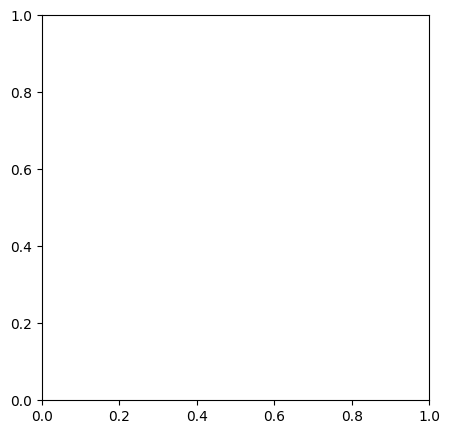

In [57]:
with open(os.path.join(ngb_prediction_path, "ngboost_predictions_list.pkl"), "rb") as f:
    predictions_list = pickle.load(f)

mean_list = []
std_list = []

for id, run in enumerate(predictions_list):
    mean = run['mean_prediction']
    std = run['std_prediction']
    # calibration Curve with UCT
    uct.viz.plot_calibration(mean, std, y_test)
    plt.savefig(os.path.join(ngb_result_path, f"calibration_run_{id+1}.png"))
    plt.close()

    # adversarial group calibration
    uct.viz.plot_adversarial_group_calibration(mean, std, y_test)
    plt.savefig(os.path.join(ngb_result_path, f"adversarial_group_calibration_run_{id+1}.png"))
    plt.close()

# predictions_list enthält pro Run ein Array mit 10403 Werten
mean_matrix = np.array(mean_list)  # Shape: (n_runs, 10403)
std_matrix = np.array(std_list)    # Shape: (n_runs, 10403)

# Mittelwert und Std für jeden Datenpunkt über alle Runs
mean_per_datapoint = np.mean(mean_matrix, axis=0)  # Shape: (10403,)
std_per_datapoint = np.mean(std_matrix, axis=0)    # Shape: (10403,)

# calibration Curve with UCT
uct.viz.plot_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(ngb_result_path, "calibration_run_mean.png"))
plt.close()
# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(ngb_result_path, "adversarial_group_calibration_run_mean.png"))
plt.close()
